1. Using sc2reader to load a replay into a Python object
1. Examining some of the basic replay information in the result
1. Parsing the contest details into a usable object
1. Visualizing the contest with graphics
1. Storing the processed replay in Cloudant

## Checking Python Version

In [ ]:
working_version = '3.7.7'
pythons = ['python','python3']

found_python = False
for python in pythons:
    p = !{python} -V
    if working_version in p[0]:
        found_python = True
        print('You\'re using Python %s with the alias %s.' % (working_version, python))

if not found_python:
    raise Exception('Unable to find Python %s in your environment.' % working_version)

## Setup prerequisites
### Install the _sc2reader_, _cloudant_ and _bokeh_ Python packages from PyPI

* **_sc2reader_** is an open source library for processing StarCraft 2 replay files.
* **_cloudant_** is the Python client for using the Cloudant NoSQL DB.
* **_bokeh_** is a Python interactive visualization library.
* **_seaborn_** is a Python data visualization library based on matplotlib.


In [ ]:
dependencies = 'bokeh sc2reader s2protocol pandas seaborn matplotlib numpy'
split_ds = dependencies.split(' ')
pips = ['pip','pip3']

found_pip = False

for pip in pips:
    p = !{pip}
    if 'not found' not in p[0]:
        found_pip = True
        pip_list = !{pip} 'list'
        flat_pip_list = ' '.join(pip_list)

        if any(word+' ' not in flat_pip_list for word in split_ds):
            !{pip} install {dependencies}
        else:
            print('You have all the necessary dependencies installed.')

if not found_pip:
    raise Exception('Unable to find pip or pip3. How are you even running this?')

In [ ]:


# import glob
# from sys import platform

# paths = None
# if platform == 'darwin':
#     paths = [path for path in glob.glob('/Applications/StarCraft II/Replays/*.SC2Replay', recursive=True)]
# elif platform in ['win32','win64']:
#     paths = [path for path in glob.glob('/Applications/StarCraft II/Replays/*.SC2Replay', recursive=True)]
    

In [104]:
import pandas as pd
import sc2reader
from sc2reader.engine.plugins import APMTracker, ContextLoader, SelectionTracker
from sc2reader.events import PlayerStatsEvent, UnitBornEvent, UnitDiedEvent, UnitDoneEvent, UnitTypeChangeEvent, UpgradeCompleteEvent
import glob

paths = [path for path in glob.glob('./folder/**/*.SC2Replay', recursive=True)]
# paths = [path for path in glob.glob('/Applications/StarCraft II/Replays/*.SC2Replay', recursive=True)]

replay_file = './king_sejong_station_le.sc2replay'
replay_file = paths[1]

replay = sc2reader.load_replay(
    replay_file,
    engine=sc2reader.engine.GameEngine(plugins=[ContextLoader(), APMTracker(), SelectionTracker()]))

print('Replay successfully loaded.')

Replay successfully loaded.


## Load the replay

Load in the replay with sc2reader. We'll use bytes that the inserted code read from our
IBM Cloud Object Storage container.

In [105]:
print("Date: %s" % replay.date)
print("Map Name: " + replay.map_name)
for player in replay.players:
    print("%s: %s" % (player.result, player))

Date: 2020-08-30 12:27:01
Map Name: Submarine LE
Loss: Player 1 - Seither (Terran)
Win: Player 2 - Probe (Protoss)


## Print basic replay information

With the replay added, we can now inspect the object in the notebook. We can easily get information
like date, map name, participants, winner/loser, etc. 

In [106]:
import pickle

with open('pieces.pickle', 'rb') as f:
    pieces = pickle.load(f)

pieces.keys()

dict_keys(['vespene_units', 'supply_units', 'worker_units', 'base_units', 'ground_units', 'air_units', 'tech_units', 'army_units', 'army_air', 'army_ground'])

In [107]:
# Establish our event parsers

def handle_count(caller, event, key, add_value, start_val=0):
    if len(caller.players[event.unit.owner.pid][key]) == 0:
        caller.players[event.unit.owner.pid][key].append((0, 0))
    # Get the last value
    last_val = caller.players[event.unit.owner.pid][key][-1][1]
    caller.players[event.unit.owner.pid][key].append((event.frame, last_val + add_value))


def handle_expansion_events(caller, event):
    if type(event) is UnitDoneEvent:
        unit = str(event.unit).split()[0]
        if unit in pieces['base_units']:
            caller.players[event.unit.owner.pid]["expansion_event"].append((event.frame, "+", unit))
            handle_count(caller, event, "expansion_buildings", 1, start_val=1)
    elif type(event) is UnitDiedEvent:
        unit = str(event.unit).split()[0]
        if unit in pieces['base_units']:
            caller.players[event.unit.owner.pid]["expansion_event"].append((event.frame, "-", unit))
            handle_count(caller, event, "expansion_buildings", -1, start_val=1)
    elif type(event) is UnitTypeChangeEvent:
        if event.unit.name in pieces['base_units']:
            caller.players[event.unit.owner.pid]["expansion_event"].append((event.frame, "*", event.unit.name))


def handle_worker_events(caller, event):
    if type(event) is PlayerStatsEvent:
        caller.players[event.pid]["workers_active"].append((event.frame, event.workers_active_count))
    elif type(event) is UnitBornEvent:
        unit = str(event.unit).split()[0]
        if unit in pieces['worker_units']:
            caller.players[event.control_pid]["worker_event"].append((event.frame, "+", unit))
    elif type(event) is UnitDiedEvent:
        unit = str(event.unit).split()[0]
        if unit in pieces['worker_units']:
            caller.players[event.unit.owner.pid]["worker_event"].append((event.frame, "-", unit))


def handle_supply_events(caller, event):
    if type(event) is PlayerStatsEvent:
        caller.players[event.pid]["supply_available"].append((event.frame, int(event.food_made)))
        caller.players[event.pid]["supply_consumed"].append((event.frame, int(event.food_used)))
        utilization = 0 if event.food_made == 0 else event.food_used / event.food_made
        caller.players[event.pid]["supply_utilization"].append((event.frame, utilization))
        worker_ratio = 0 if event.food_used == 0 else event.workers_active_count / event.food_used
        caller.players[event.pid]["worker_supply_ratio"].append((event.frame, worker_ratio))
    elif type(event) is UnitDoneEvent:
        unit = str(event.unit).split()[0]
        if unit in pieces['supply_units']:
            caller.players[event.unit.owner.pid]["supply_event"].append((event.frame, "+", unit))
    elif type(event) is UnitBornEvent:
        # Specifically for Overlord
        unit = str(event.unit).split()[0]
        if unit == "Overlord":
            caller.players[event.control_pid]["supply_event"].append((event.frame, "+", unit))
    elif type(event) is UnitDiedEvent:
        # Buildings/ Overlord/Overseer
        unit = str(event.unit).split()[0]
        if unit in pieces['supply_units']:
            caller.players[event.unit.owner.pid]["supply_event"].append((event.frame, "-", unit))
    elif type(event) is UnitTypeChangeEvent:
        if event.unit_type_name == "Overseer":
            caller.players[event.unit.owner.pid]["supply_event"].append((event.frame, "*", event.unit_type_name))


def handle_vespene_events(caller, event):
    if type(event) is PlayerStatsEvent:
        caller.players[event.pid]["vespene_available"].append((event.frame, event.vespene_current))
        caller.players[event.pid]["vespene_collection_rate"].append((event.frame, event.vespene_collection_rate))
        vesp_per_worker = 0 if event.workers_active_count == 0 else event.vespene_collection_rate / event.workers_active_count
        caller.players[event.pid]["vespene_per_worker_rate"].append((event.frame, vesp_per_worker))
        caller.players[event.pid]["vespene_cost_active_forces"].append((event.frame, event.vespene_used_active_forces))
        caller.players[event.pid]["vespene_spend"].append((event.frame, event.vespene_used_current))
        caller.players[event.pid]["vespene_value_current_technology"].append((event.frame, event.vespene_used_current_technology))
        caller.players[event.pid]["vespene_value_current_army"].append((event.frame, event.vespene_used_current_army))
        caller.players[event.pid]["vespene_value_current_economic"].append((event.frame, event.vespene_used_current_economy))
        caller.players[event.pid]["vespene_queued"].append((event.frame, event.vespene_used_in_progress))
        caller.players[event.pid]["vespene_queued_technology"].append((event.frame, event.vespene_used_in_progress_technology))
        caller.players[event.pid]["vespene_queued_army"].append((event.frame, event.vespene_used_in_progress_technology))
        caller.players[event.pid]["vespene_queued_economic"].append((event.frame, event.vespene_used_in_progress_economy))
    elif type(event) is UnitDoneEvent:
        unit = str(event.unit).split()[0]
        if unit in pieces['vespene_units']:
            caller.players[event.unit.owner.pid]["vespene_event"].append((event.frame, "+", unit))
    elif type(event) is UnitDiedEvent:
        unit = str(event.unit).split()[0]
        if unit in pieces['vespene_units']:
            caller.players[event.unit.owner.pid]["vespene_event"].append((event.frame, "-", unit))


def handle_resources_events(caller, event):
    if type(event) is PlayerStatsEvent:
        caller.players[event.pid]["mineral_destruction"].append((event.frame, event.minerals_killed))
        caller.players[event.pid]["mineral_destruction_army"].append((event.frame, event.minerals_killed_army))
        caller.players[event.pid]["mineral_destruction_economic"].append((event.frame, event.minerals_killed_economy))
        caller.players[event.pid]["mineral_destruction_technology"].append((event.frame, event.minerals_killed_technology))
        caller.players[event.pid]["mineral_loss"].append((event.frame, event.minerals_lost))
        caller.players[event.pid]["mineral_loss_army"].append((event.frame, event.minerals_lost_army))
        caller.players[event.pid]["mineral_loss_economic"].append((event.frame, event.minerals_lost_economy))
        caller.players[event.pid]["mineral_loss_technology"].append((event.frame, event.minerals_lost_technology))

        caller.players[event.pid]["vespene_destruction"].append((event.frame, event.vespene_killed))
        caller.players[event.pid]["vespene_destruction_army"].append((event.frame, event.vespene_killed_army))
        caller.players[event.pid]["vespene_destruction_economic"].append((event.frame, event.vespene_killed_economy))
        caller.players[event.pid]["vespene_destruction_technology"].append((event.frame, event.vespene_killed_technology))
        caller.players[event.pid]["vespene_loss"].append((event.frame, event.vespene_lost))
        caller.players[event.pid]["vespene_loss_army"].append((event.frame, event.vespene_lost_army))
        caller.players[event.pid]["vespene_loss_economic"].append((event.frame, event.vespene_lost_economy))
        caller.players[event.pid]["vespene_loss_technology"].append((event.frame, event.vespene_lost_technology))


def handle_ground_events(caller, event):
    if type(event) is UnitDoneEvent:
        unit = str(event.unit).split()[0]
        if unit in pieces['ground_units']:
            count_name = "_".join(["building", unit, "count"])
            caller.players[event.unit.owner.pid]["ground_building"].append((event.frame, "+", unit))
            handle_count(caller, event, count_name, 1)
    elif type(event) is UnitDiedEvent:
        unit = str(event.unit).split()[0]
        if unit in pieces['ground_units']:
            count_name = "_".join(["building", unit, "count"])
            caller.players[event.unit.owner.pid]["ground_building"].append((event.frame, "-", unit))
            handle_count(caller, event, count_name, -1)
    elif type(event) is UnitTypeChangeEvent:
        if event.unit_type_name == "LurkerDen":
            count_name = "_".join(["building", event.unit_type_name, "count"])
            caller.players[event.unit.owner.pid]["ground_building"].append((event.frame, "*", event.unit_type_name))
            handle_count(caller, event, count_name, 1)


def handle_air_events(caller, event):
    if type(event) is UnitDoneEvent:
        unit = str(event.unit).split()[0]
        if unit in pieces['air_units']:
            count_name = "_".join(["building", unit, "count"])
            caller.players[event.unit.owner.pid]["air_building"].append((event.frame, "+", unit))
            handle_count(caller, event, count_name, 1)
    elif type(event) is UnitDiedEvent:
        unit = str(event.unit).split()[0]
        if unit in pieces['air_units']:
            count_name = "_".join(["building", unit, "count"])
            caller.players[event.unit.owner.pid]["air_building"].append((event.frame, "-", unit))
            handle_count(caller, event, count_name, -1)
    elif type(event) is UnitTypeChangeEvent:
        if event.unit_type_name == "GreaterSpire":
            count_name = "_".join(["building", event.unit_type_name, "count"])
            caller.players[event.unit.owner.pid]["air_building"].append((event.frame, "*", event.unit_type_name))
            handle_count(caller, event, count_name, 1)


def handle_unit_events(caller, event):
    if type(event) is UnitBornEvent:
        unit = event.unit_type_name
        if unit in pieces['army_units']:
            unit_count_name = "_".join(["unit", unit, "count"])
            caller.players[event.control_pid]["army_event"].append((event.frame, "+", unit))
            handle_count(caller, event, unit_count_name, 1)
            if unit in pieces['army_air']:
                handle_count(caller, event, "army_air", 1)
            elif unit in pieces['army_ground']:
                handle_count(caller, event, "army_ground", 1)
            handle_count(caller, event, "army_count", 1)
    elif type(event) is UnitDoneEvent:
        unit = str(event.unit).split()[0]
        if unit in pieces['army_units']:
            unit_count_name = "_".join(["unit", unit, "count"])
            caller.players[event.unit.owner.pid]["army_event"].append((event.frame, "+", unit))
            handle_count(caller, event, unit_count_name, 1)
            if unit in pieces['army_air']:
                handle_count(caller, event, "army_air", 1)
            elif unit in pieces['army_ground']:
                handle_count(caller, event, "army_air", 1)
            handle_count(caller, event, "army_count", 1)
    elif type(event) is UnitDiedEvent:
        unit = str(event.unit).split()[0]
        if unit in pieces['army_units']:
            unit_count_name = "_".join(["unit", unit, "count"])
            caller.players[event.unit.owner.pid]["army_event"].append((event.frame, "-", unit))
            if unit in pieces['army_air']:
                handle_count(caller, event, "army_air", -1)
            elif unit in pieces['army_ground']:
                handle_count(caller, event, "army_ground", -1)
            handle_count(caller, event, unit_count_name, -1)
            handle_count(caller, event, "army_count", -1)
    elif type(event) is UnitTypeChangeEvent:
        unit = str(event.unit).split()[0]
        if event.unit_type_name in pieces['army_units']:
            unit_count_name = "_".join(["unit", event.unit_type_name, "count"])

            caller.players[event.unit.owner.pid]["army_event"].append((event.frame, "*", unit))

            handle_count(caller, event, unit_count_name, 1)


def handle_tech_events(caller, event):
    if type(event) is UnitDoneEvent:
        unit = str(event.unit).split()[0]
        if unit in pieces['tech_units']:
            caller.players[event.unit.owner.pid]["tech_building"].append((event.frame, "+", unit))
    elif type(event) is UnitDiedEvent:
        unit = str(event.unit).split()[0]
        if unit in pieces['tech_units']:
            caller.players[event.unit.owner.pid]["tech_building"].append((event.frame, "-", unit))
    elif type(event) is UnitTypeChangeEvent:
        if event.unit_type_name in ["GreaterSpire", "LurkerDen"]:
            caller.players[event.unit.owner.pid]["tech_building"].append((event.frame, "*", event.unit_type_name))


def handle_upgrade_events(caller, event):
    if type(event) is UpgradeCompleteEvent and event.frame > 0:
        if not event.upgrade_type_name.startswith("Spray"):
            caller.players[event.pid]["upgrades"].append((event.frame, event.upgrade_type_name))


def handle_mineral_events(caller, event):
    if type(event) is PlayerStatsEvent:
        caller.players[event.pid]["minerals_available"].append((event.frame, event.minerals_current))
        caller.players[event.pid]["mineral_collection_rate"].append((event.frame, event.minerals_collection_rate,))
        caller.players[event.pid]["mineral_cost_active_forces"].append((event.frame, event.minerals_used_active_forces))
        mins_per_worker = 0 if event.workers_active_count == 0 else event.minerals_collection_rate / event.workers_active_count
        caller.players[event.pid]["mineral_per_worker_rate"].append((event.frame, mins_per_worker))
        caller.players[event.pid]["mineral_spend"].append((event.frame, event.minerals_used_current))
        caller.players[event.pid]["mineral_value_current_technology"].append((event.frame, event.minerals_used_current_technology))
        caller.players[event.pid]["mineral_value_current_army"].append((event.frame, event.minerals_used_current_army))
        caller.players[event.pid]["mineral_value_current_economic"].append((event.frame, event.minerals_used_current_economy))
        caller.players[event.pid]["mineral_queued"].append((event.frame, event.minerals_used_in_progress))
        caller.players[event.pid]["mineral_queued_technology"].append((event.frame, event.minerals_used_in_progress_technology))
        caller.players[event.pid]["mineral_queued_army"].append((event.frame, event.minerals_used_in_progress_army))
        caller.players[event.pid]["mineral_queued_economic"].append((event.frame, event.minerals_used_in_progress_economy))

In [108]:
# Aggregate all of our event parsers for use by our ReplayData class

handlers = [handle_expansion_events, handle_worker_events, handle_supply_events, handle_mineral_events,
            handle_vespene_events, handle_ground_events, handle_air_events, handle_tech_events, handle_upgrade_events,
            handle_unit_events]

In [109]:
# Below we define our class ReplayData for helping us structure and process our replay files

class ReplayData:
    __parsers__ = handlers

    @classmethod
    def parse_replay(cls, replay=None, replay_file=None, file_object=None):
        
        replay_data = ReplayData(replay_file)
        try:
            # This is the engine that holds some required plugins for parsing
            engine = sc2reader.engine.GameEngine(plugins=[ContextLoader(), APMTracker(), SelectionTracker()])
               
            if replay:
                pass
            elif replay_file and not file_object:
                # Then we are not using ObjectStorage for accessing replay files
                replay = sc2reader.load_replay(replay_file, engine=engine)
            elif file_object:
                # We are using ObjectStorage to access replay files
                replay = sc2reader.load_replay(file_object, engine=engine)
            else:
                pass
            
            # Get the number of frames (one frame is 1/16 of a second)
            replay_data.frames = replay.frames
            # Gets the game mode (if available)
            replay_data.game_mode = replay.real_type
            # Gets the map hash (if we want to download the map, or do map-based analysis)
            replay_data.map_hash = replay.map_hash
            
            # Use the parsers to get data
            for event in replay.events:
                for parser in cls.__parsers__:
                    parser(replay_data, event)
            
            # Check if there was a winner
            if replay.winner is not None:
                replay_data.winners = replay.winner.players
                replay_data.losers = [p for p in replay.players if p not in replay.winner.players]
            else:
                replay_data.winners = []
                replay_data.losers = []
            # Check to see if expansion data is available
            replay_data.expansion = replay.expansion
            return replay_data
        except:
            # print our error and return NoneType object
            print_exc()
            return None
        
    def as_dict(self):
        return {
            "processed_on": datetime.utcnow().isoformat(),
            "replay_name": self.replay,
            "expansion": self.expansion,
            "frames": self.frames,
            "mode": self.game_mode,
            "map": self.map_hash,
            "matchup": "v".join(sorted([s.detail_data["race"][0].upper() for s in self.winners + self.losers])),
            "winners": [(s.pid, s.name, s.detail_data['race']) for s in self.winners],
            "losers": [(s.pid, s.name, s.detail_data['race']) for s in self.losers],
            "stats_names": [k for k in self.players[1].keys()],
            "stats": {player: data for player, data in self.players.items()}
                }

    def __init__(self, replay):
        self.players = defaultdict(lambda: defaultdict(list))
        self.replay = replay
        self.winners = []
        self.losers = []
        self.expansion = None

## Visualize and compare replay events

The replay file was processed to add event statistics using pandas and
helper functions.
* Bokeh is used to create Nelson rules charts.
* Seaborn is used for box plot charts.

In [110]:
from datetime import datetime
from collections import defaultdict
from traceback import print_exc

from bokeh.io import output_notebook, reset_output
from bokeh.models import Span, Range1d, Legend, BoxAnnotation, HoverTool, Arrow, NormalHead
from bokeh.plotting import figure, show, gridplot, ColumnDataSource

output_notebook()

Loading BokehJS ...

In [111]:
def merge(i, last_entry, sign=None, length=3):
    if last_entry is not None:
        if sign is not None:
            # Check to see if this is a continuation
            if last_entry[1] == i + length - 1 and last_entry[2] == sign:
                return [(last_entry[0], i + length, sign)]
            else:
                return [last_entry, (i, i + length, sign)]
        else:
            # Check to see if this is a continuation
            if last_entry[1] == i + length - 1:
                return [(last_entry[0], i + length)]
            else:
                return [last_entry, (i, i + length)]
    else:
        if sign is not None:
            return [(i, i + length, sign)]
        else:
            return [(i, i + length)]
                

                
def detect_nelson_bias(src_data, x_bar):
    # Bias is defined as 9 or more consecutive points sitting above or below our x-bar line
    bias_ranges = []
    length = 9
    for i in range(len(src_data) - length):
        last_entry = bias_ranges.pop() if len(bias_ranges) > 0 else None
        if all([src_data[k] > x_bar for k in range(i, i + length)]):
            sign = "+"
            bias = merge(i, last_entry, sign=sign, length=length)
            bias_ranges.extend(bias)
        elif all([src_data[k] < x_bar for k in range(i, i+length)]):
            sign = "-"
            bias = merge(i, last_entry, sign=sign, length=length)
            bias_ranges.extend(bias)
        else:
            if last_entry:
                bias_ranges.append(last_entry)
                
    return bias_ranges

def detect_nelson_trend(src_data, std):
    # Trend is defined as 6 or more consecutive points all increasing or decreasing (or 6 or more consecutive non(increasing, decreasing) where difference between start and end points greater than 1.5 standard deviations )
    trend_ranges = []
    length = 6
    for i in range(len(src_data) - length):
        last_entry = trend_ranges.pop() if len(trend_ranges) > 0 else None
        if (all(x<y for x, y in zip(src_data[i:i+length], src_data[i+1:i+length]))
            or (all(x<=y for x,y in zip(src_data[i:i+length], src_data[i+1:i+length])) 
                and abs(src_data[i] - src_data[i+length]) >= 1.5*std)):
            sign = "+"
            trend_ranges.extend(merge(i, last_entry, sign=sign, length=length))
        elif (all(x>y for x, y in zip(src_data[i:i+length], src_data[i+1:i+length])) 
            or (all(x>=y for x,y in zip(src_data[i:i+length], src_data[i+1:i+length]))
                and abs(src_data[i] - src_data[i+length]) >= 1.5*std)):
            sign = "-"
            trend_ranges.extend(merge(i, last_entry, sign=sign, length=length))
        else:
            if last_entry:
                trend_ranges.append(last_entry)
    
    return trend_ranges
            
def detect_nelson_oscillation(src_data):
    # Oscillation is defined as 14 or more consecutive points, all alternating in direction
    diff = lambda x, y: 1 if y - x > 0 else -1 if y - x  < 0 else None
    oscillation_ranges = []
    length=14
    deltas = []
    for i in range(len(src_data) - length):
        last_entry = oscillation_ranges.pop() if len(oscillation_ranges) > 0 else None
        sign = None
        is_oscillating = True
        for curr in range(i, i + length - 1):
            if sign == None and curr == i:
                sign = diff(src_data[curr], src_data[curr + 1])
            elif sign is None and curr != i:
                is_oscillating = False
                break
            else:
                new_sign = diff(src_data[curr], src_data[curr + 1])
                if new_sign is None or new_sign == sign:
                    is_oscillating = False
                    break
                elif new_sign != sign and new_sign is not None:
                    sign = new_sign
        if is_oscillating:
            # check if this is a continuation of a previous oscillation
            oscillation_ranges.extend(merge(i, last_entry, length=length))
            
        else:
            if last_entry:
                oscillation_ranges.append(last_entry)
    
    return oscillation_ranges


def avg_last_minute(process, pid, time, replay):
    data = pd.DataFrame({
            "Data": [k[1] for k in replay.stats[pid-1][process]]},
            index=[int(k[0]/16) for k in replay.stats[pid - 1][process]])
    
    rolling = data.rolling(6).mean()
    pct_change = data.pct_change()
    ndx = data.index.get_loc(time, method="ffill")

    prev_ndx = max(ndx - 1, 0)
    print(ndx, prev_ndx)
    r_mean = rolling.get_value(rolling.index[ndx], "Data")
    prev_mean = rolling.get_value(rolling.index[prev_ndx], "Data")
    print(r_mean, prev_mean)
    print(pct_change)
    pcng = pct_change.get_value(rolling.index[ndx], "Data")

    change = "⬆️" if r_mean > prev_mean else "⬇️" if r_mean < prev_mean else ""
    
    return r_mean if not pd.isnull(r_mean) else 0, change, pcng if not (pd.isnull(pcng) or pcng != np.Inf) else 0
    

# Define Nelson Rules Chart Generator
def nelson_rules_chart_generator(src, timeseries, player, pid, process_name, unit_name, replay, plot_width=350,fill_color="blue", line_color="blue", line_width=2, annotations=None, fixed_lcl=None, fixed_ucl=None):
    # We strip the first two data points (first data point is 0 and second data point should roughly be the same for all games)
    x_bar = src[2:].mean()
    std = src[2:].std()
    ctrl_limits = [x_bar + (k*std) for k in range(-3, 4)]
    ctrl_labels = ["LCL", "-2σ", "-1σ", "x-bar", "1σ", "2σ", "UCL"]
    ctrl_colors = ["#55597F", "#5D6DFF","#A9B2FF","#000000", "#FF9E9F", "#FF5253","#7F2929"]
    ctrl_dash = ["solid", "dashed", "dashed", "solid", "dashed", "dashed", "solid"]
    ctrl_legend = ["{0} - {1:10.4f}".format(cl[0], cl[1]) for cl in zip(ctrl_labels, ctrl_limits)]
    ctrl_width = [3, 2, 2, 3, 2, 2, 3]
    
    
    significant = lambda x: x > ctrl_limits[5] or x < ctrl_limits[1]
    
    hover = HoverTool(
        tooltips=[
            ("time", "@x"),
            ("value", "@y")
        ])
    
    p = figure(plot_width=plot_width, plot_height=300, x_axis_label="Game Time (in seconds)", y_axis_label=unit_name, tools=[hover], toolbar_location="above")
    # Generate control lines
    lines = []
    source = ColumnDataSource(data=dict(x=[x/16 for x in timeseries], 
                                        y=src,
                                        alpha=[1 if significant(y) and ndx > 2 else 0.7 for ndx, y in enumerate(src)], 
                                        radius=[6 if significant(y) and ndx > 2 else 4 for ndx, y in enumerate(src)], 
                                        ))
    for ndx, cl in enumerate(ctrl_limits):
        limit = cl
            
        lines.append(p.line([x/16 for x in timeseries], 
                            [limit]*len(timeseries), 
                            line_width=ctrl_width[ndx], 
                            line_dash=ctrl_dash[ndx], 
                            tags=[ctrl_labels[ndx] if k == 0 else None for k, _ in enumerate(timeseries)],  
                            line_color=ctrl_colors[ndx]))
        
    
    p.circle("x", "y",
             source=source,
             alpha="alpha", 
             radius="radius", 
             fill_color=fill_color,  
             line_width=line_width)
    
    
    # Handle bias
    bias_ranges = detect_nelson_bias(src, x_bar)
    for rng in bias_ranges:
        if rng[2] is "+":
            p.add_layout(BoxAnnotation(bottom=x_bar, top=ctrl_limits[-1], left=timeseries[rng[0]]/16, right=timeseries[rng[1]]/16, fill_color="green"))
        elif rng[2] is "-":
            p.add_layout(BoxAnnotation(top=x_bar, bottom=ctrl_limits[0], left=timeseries[rng[0]]/16, right=timeseries[rng[1]]/16, fill_color="red"))
            
    # Handle trends
    trend_ranges = detect_nelson_trend(src, std)
    for rng in trend_ranges:
        if rng[2] is "+":
            p.add_layout(Arrow(end=NormalHead(line_color="goldenrod",
                                              fill_color="goldenrod"),
                               x_start=timeseries[rng[0]]/16,
                               y_start=src[rng[0]],
                               x_end=timeseries[rng[1]]/16,
                               y_end=src[rng[1]],
                               line_width=4,
                               line_alpha=0.6,
                               line_dash="solid"))
        elif rng[2] is "-":
            p.add_layout(Arrow(end=NormalHead(line_color="#7F0000",
                                              fill_color="#7F0000"),
                               x_start=timeseries[rng[0]]/16,
                               y_start=src[rng[0]],
                               x_end=timeseries[rng[1]]/16,
                               y_end=src[rng[1]],
                               line_width=4,
                               line_alpha=0.6,
                               line_dash="solid"))
    
    p.title.text = "{0} for {1}".format(unit_name, player)
    p.y_range = p.y_range = Range1d(ctrl_limits[0] - 0.125 * ctrl_limits[0],  1.125 * ctrl_limits[-1])
    
    legend = Legend(items=list(zip(ctrl_legend, [[l] for l in lines])), location=(10,-30))
    p.add_layout(legend, "right")
    
    return p, ctrl_limits, min(src[2:]), max(src[2:]), timeseries[-1]

In [112]:
replay_object = ReplayData.parse_replay(replay=replay)
replay_dict = replay_object.as_dict()

players = {}
for player in replay_dict["winners"]:
    players[int(player[0])] = {"full": "Winning Player {num}: {name} ({race})".format(num=player[0], name=player[1], race=player[2]),
                               "short": "{name} ({race})".format(name=player[1], race=player[2]) }
for player in replay_dict["losers"]:
    players[int(player[0])] = {"full": "Losing Player {num}: {name} ({race})".format(num=player[0], name=player[1], race=player[2]),
                               "short": "{name} ({race})".format(name=player[1], race=player[2]) }

econ = ["mineral_collection_rate", "vespene_collection_rate", "workers_active", "supply_utilization", "worker_supply_ratio"]
units = ["Minerals per Minute (MPM)", "Vespene per Minute (VPM)", "Workers", "Supply Used / Supply Available", "Workers / Supply Used"]

player_charts = defaultdict(dict)
player_aggregate = defaultdict(dict)

In [113]:
for pid, player in players.items():
    for ndx, process in enumerate(econ):
        # Generate charts per player
        timeseries = [k[0] for k in replay_dict["stats"][pid][process]]
        proc_data = [j[1] for j in replay_dict["stats"][pid][process]]

        player_charts[pid][process], limits, v_min, v_max, game_length = nelson_rules_chart_generator(
            pd.Series(proc_data),
            timeseries,
            player["full"],
            pid,
            process,
            units[ndx],
            replay,
            fixed_lcl=0)
        player_aggregate[process][pid] = proc_data

grid = [[player_charts[k][measurement] for k in player_charts] for ndx, measurement in enumerate(econ)]

show(gridplot(grid, sizing_mode="scale_width"))

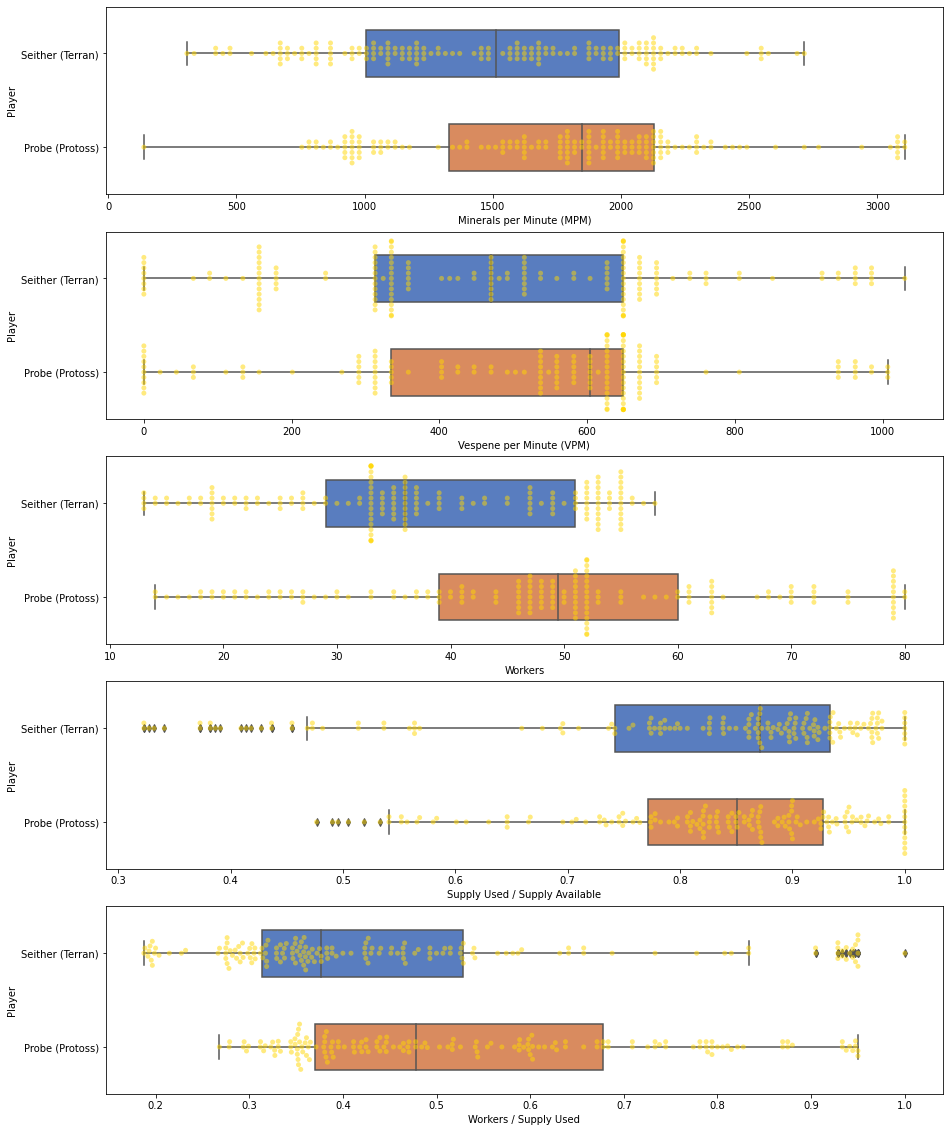

In [114]:
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=len(grid),ncols=1,figsize=(15,20))

for ndx in range(len(grid)):

    sample_max = min([len(player_aggregate[econ[ndx]][j]) for j in player_aggregate[econ[ndx]].keys()])
    # Remember, we are removing the first 20 samples (beginning of game should be the same for all, so data is useless)
    frame = pd.DataFrame({ units[ndx]: [player_aggregate[econ[ndx]][1][k] for k in range(2,sample_max)] + [player_aggregate[econ[ndx]][2][l] for l in range(2,sample_max)],
                           "Player": [players[(i//sample_max) + 1]["short"] for i in range(0,len(players.keys())*(sample_max - 2))]})
    
    bp = seaborn.boxplot(x=units[ndx], orient="h", y='Player',  data=frame,  width=0.5, palette="muted", ax=axes[ndx])
    bp = seaborn.swarmplot(x=units[ndx], y='Player', data=frame,  color='gold', alpha=0.5, ax=axes[ndx])

plt.show()

# Storing Replay Files

Now that we have loaded and processed the replay, we can store
it for future use and aggregation.

The replay_object has an as_dict() method to give us JSON.

We'll store this in Cloudant for future use.

1. Connect to Cloudant with our IBM Cloud credentials.
2. Create 'sc2replays' and 'sc2recents' databases.
3. Store the current replay as a document in the 'sc2replays' database.
4. Store the current replay as a document in the 'sc2recents' database and remove the older replays.

In [ ]:
# Peek at what is in the object?
# This creates a lot of output, but if you are curious just uncomment the following 2 lines:

# from pprint import pprint
# pprint(replay_object.as_dict())

In [ ]:
# from cloudant.client import Cloudant

# # Some extra code here helps catch setup errors.
# try:
#     sc2replay_creds = credentials_1
#     print("Cloudant credentials added for storing replay data as JSON.")
# except NameError:
#     print('\n'
#           'SETUP ERROR: Please follow the directions to add Cloudant credentials to the notebook.\n'
#           '             You may need jupyto rename the credentials_* variable.')
#     raise

# # Now we need to send this data to 2 databases "sc2replays for aggregating, and sc2recents.

# # Connect to cloudant service with IBM Cloud IAM credentials username and apikey.
# esports = Cloudant.iam(sc2replay_creds["username"], sc2replay_creds["apikey"], connect=True)
    
# print(esports.all_dbs())
# session = esports.session()

# if 'sc2replays' not in esports.all_dbs():
#         esports.create_database('sc2replays')
        
# sc2replays = esports['sc2replays']
# document = sc2replays.create_document(replay_object.as_dict())
# if document.exists():
#     print("sc2replays entry saved. Latest id: {0}".format(document["_id"]))
        
# if 'sc2recents' not in esports.all_dbs():
#     esports.create_database('sc2recents')
        
# sc2recents = esports['sc2recents']
# # clear out everything in sc2recents db
# for d in sc2recents:
#     d.delete()
        
# document = sc2recents.create_document(replay_object.as_dict())
# if document.exists():
#     print("sc2recents entry saved. Latest id: {0}".format(document["_id"]))

# License

Licensed under the Apache License, Version 2.0 (the "License"); you may
not use this file except in compliance with the License. You may obtain
a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License.

In [99]:
import sc2reader
from collections import defaultdict
from datetime import datetime
from sc2reader.engine.plugins import APMTracker, ContextLoader, SelectionTracker
from sc2reader.events import PlayerStatsEvent, UnitBornEvent, UnitDiedEvent, UnitDoneEvent, UnitTypeChangeEvent, UpgradeCompleteEvent
import glob


path = '/Applications/StarCraft II/Replays/'
races = []

winner = []
loser = []

# paths = [path for path in glob.glob('/Applications/StarCraft II/Replays/*.SC2Replay', recursive=True)]
paths = [path for path in glob.glob('./folder/**/*.SC2Replay', recursive=True)]

replays = []

# number of replays to look into
count = 10
print('Found %d StarCraft II replays, but only loading %d replays.' % (len(paths), count))

for i, path in enumerate(paths[:count]):
    replay = sc2reader.load_replay(path, engine=sc2reader.engine.GameEngine(plugins=[ContextLoader(), APMTracker(), SelectionTracker()]))

    races.append(replay.players[0].play_race[0])
    replays.append(replay)
    
    print('\r%6.2f%% complete' % ((i+1)/count*100), end='', flush=True)

#     for player in replay.players:
#         if player.result == 'Win':
#             winner.append(player)
#         else:
#             loser.append(player)

# print('\n', races)

from google.colab import drive
drive.mount('/content/gdrive')
from tensorflow.python.client import device_lib
from tensorflow import keras

%tensorflow_version 2.x

device_lib.list_local_devices()

Found 799 StarCraft II replays, but only loading 10 replays.
100.00% complete

In [119]:
import sc2reader
from sc2reader.events import *

replay = replays[0]

lst = []

for event in replay.player[1].events:
    if isinstance(event, events.CameraEvent):  # Change of camera position    
        try:
            lst.append([event.pid, event.player, event.second, event.x, event.y, 'CameraEvent', event.frame])
        except:
            print('error')
    elif isinstance(event, events.CommandEvent): # Player commands
        try:
            lst.append([event.pid, event.player, event.second, 'NA', 'NA', event.ability_type, event.frame])
        except:
            print('error')

In [101]:
import pandas as pd

df = pd.DataFrame(lst, columns=['id', 'player', 'seconds', 'x', 'y', 'commandType', 'frame'])

df.head(10)

,id,player,seconds,x,y,commandtype,frame
0,1,Player 1 - Seither (Terran),0,28.25,37.0078,CameraEvent,3
1,1,Player 1 - Seither (Terran),0,NA,NA,None,12
2,1,Player 1 - Seither (Terran),1,NA,NA,TargetUnit,20
3,1,Player 1 - Seither (Terran),2,30.4961,36.7578,CameraEvent,45
4,1,Player 1 - Seither (Terran),3,30.4961,37.9102,CameraEvent,51
5,1,Player 1 - Seither (Terran),3,30.4961,41.6211,CameraEvent,51
6,1,Player 1 - Seither (Terran),3,30.4961,36.7578,CameraEvent,54
7,1,Player 1 - Seither (Terran),4,34.082,36.7578,CameraEvent,69
8,1,Player 1 - Seither (Terran),4,39.5859,36.7578,CameraEvent,71
9,1,Player 1 - Seither (Terran),4,40.0977,36.7578,CameraEvent,71


In [10]:
import sc2reader
from sc2reader.engine.plugins import APMTracker, ContextLoader, SelectionTracker
from sc2reader import events
import pandas as pd
import glob

paths = [path for path in glob.glob('./folder/**/*.SC2Replay', recursive=True)]
# paths = [path for path in glob.glob('/Applications/StarCraft II/Replays/*.SC2Replay', recursive=True)]
workers = []

replay = sc2reader.load_replay(paths[0])
for event in replay.events:
	if type(event) is events.PlayerStatsEvent:
		if replay.players[0].pid == event.pid:
			workers.append([event.player, replay.players[0].pick_race[0],
				event.workers_active_count,event.minerals_collection_rate,event.second])
		else:
			workers.append([event.player,replay.players[0].pick_race[0], 
			event.workers_active_count,event.minerals_collection_rate,event.second])

work = pd.DataFrame(workers, columns=["Player", "Race", "Worker Count", "Min Collection Rate","Seconds"])

work.head()

,Player,Race,Worker Count,Min Collection Rate,Seconds
0,Player 1 - Seither (Terran),T,12,0,0
1,Player 2 - Probe (Protoss),T,12,0,0
2,Player 1 - Seither (Terran),T,12,293,10
3,Player 2 - Probe (Protoss),T,12,209,10
4,Player 1 - Seither (Terran),T,13,671,20
